In [1]:
import seaborn as sns
sns.set_context('paper')

### Load Database

In [2]:
%run AH_DATABASE.ipynb


Usage: 
  db = DB(server)          --> initializes database
  db.get_df(item)          --> returns dataframe, prices divided by 100 so copper in decimal 
  db.get_name(item)        --> returns name of item  
  db.get_last_record(item) --> returns most recent record
  db.plot(item, y)         --> plots column over time



In [3]:
db = DB('earthfury-alliance')

### Flipping Analysis
Assume you purchase at a given percentile price 'buy_pctile' of an item and flip it for a 15% profit.  By examining how minBidprice fluctuates over time, determine how many times you could perform this flip 'num_flips'.  Calulate numFlips for values of P from 1 to 100.  Determine the optimal 'buy_pctile' that maximizes num_flips and look up the corresponding minBidPrice.

In [4]:
def num_flips(item, buy_pctile, profit):
    df = db.get_df(item)
    count = 0
    buysell = 'buy'    
    
    for pct, val in df[['minBuyoutPctile','minBuyout']].to_numpy(): #apparently way faster than df.iterrows()
        # buy conditions
        if buysell=='buy' and pct < buy_pctile:
            price   = val
            buysell = 'sell'        
        # sell conditions
        if buysell=='sell' and val > price*(1+profit):
            count += 1
            buysell = 'buy'    
    return count

# def flips_by_pctiles(item, profit):
#     return [ (i/100, num_flips(item, i/100, profit)) for i in range(0,100)]

# def best_flip_pctile_at_fixed_profit(item, profit):
#     return max(flips_by_pctiles(item, profit), key=lambda x:x[1])

# def flip_by_profit_at_best_pctile(item):
#     # for all profits, 5 to 100%
#     return [(i/100, best_flip_pctile_at_fixed_profit(item, i/100)) for i in range(5,100)]

# def best_flip(item):
#     return max(flip_by_profit_at_best_pctile(item, key=lambda x:x[1]))

def get_minBuyout_at_pctile(item, pctile):
    arr = db.get_df(item)['minBuyout'].to_list()
    return np.percentile(arr, pctile*100)


In [5]:
%%time
num_flips(3818, 0.22, .15)

Wall time: 841 ms


13

In [6]:
%%time
item = 3818
steps = np.linspace(0,.99,100)

results = []
for buy_pctile in steps:
    for profit in steps:
        results.append((buy_pctile, 
                        profit, 
                        num_flips(item, buy_pctile, profit)
                       ))

df = pd.DataFrame(results, columns = ['buy_pctile', 'profit','num_flips'])
df['buy_price'] = df['buy_pctile'].apply(lambda x: get_minBuyout_at_pctile(item, x))
df['net'] = df['buy_price'] * df['num_flips'] * (df['profit']-.05)
df[df['net'] == df['net'].max()]

Wall time: 9.61 s


,buy_pctile,profit,num_flips,buy_price,net
1541,0.15,0.41,9,58.33,188.9892


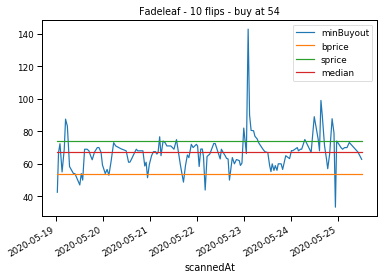

In [7]:
nflips = 10
bprice = 54
sprice = 54 * 1.37


df = db.get_df(item)
df['bprice'] = bprice
df['sprice'] = sprice
df['median'] = df['minBuyout'].median()
graph_title = f'{db.get_name(item)} - {nflips} flips - buy at {round(bprice,2)}'
df.plot('scannedAt', ['minBuyout', 'bprice', 'sprice', 'median'], title=graph_title)
 

In [ ]:
best_flip_pctile_at_fixed_profit(item, .15)

In [ ]:
arr = flip_by_profit_at_best_pctile(item)

In [ ]:
show_points([(i[0], i[1][0]) for i in arr])

In [ ]:
def find_optimal_flip(item, show_plot=False):
    flip_profile =  num_flips_over_all_pctiles(item)
    best_pctile, best_num_flips = max(flip_profile, key=lambda x:x[1])
    best_buy_price = get_minBuyout_at_pctile(item, best_pctile)
    
    if show_plot:
        df = db.get_df(item)
        df['best_buy_price'] = best_buy_price
        df['15pct_profit'] = best_buy_price * 1.15
        graph_title = f'{db.get_name(item)} - {best_num_flips} flips - buy at {round(best_buy_price,2)}'
        df.plot('scannedAt', ['minBuyout', 'best_buy_price', '15pct_profit'], title=graph_title)
    
    # return export ready data if not in plot mode
    else:
        return {
            'name'        : db.get_name(item),
            'item_id'     : item,
            'buy_price'   : int(100 * best_buy_price),         # scaling copper back into integer for export
            'min_price'   : int(100 * best_buy_price * 1.15),  # scaling copper back into integer for export
            'normal_price': int(100 * best_buy_price * 1.25),  # scaling copper back into integer for export
            'max_price'   : int(100 * best_buy_price * 1.5),   # scaling copper back into integer for export
            'num_flips'   : best_num_flips,
            'avg_quantity': int(db.get_df(item)['quantity'].mean())
        }

find_optimal_flip(3818, show_plot=True)        

In [ ]:
find_optimal_flip(2770, show_plot=True)

In [ ]:
find_optimal_flip(2770, show_plot=False)

### Run All Materials

In [ ]:
%run ITEMS.ipynb

In [ ]:
def run_analysis(list_of_items):
    results = []
    print(f'running for {len(list_of_items)} items')
    for i in range(0, len(list_of_items)):
        item = list_of_items[i]
        
        # catch no data errors with try/except
        try:
            results.append(find_optimal_flip(item))
        except: 
            print(f'! ERROR - {item}, {db.get_name(item)}')

        # print progress
        if i%10 ==0:
            print(f' ...{i} done')   
    print('COMPLETE')
    return pd.DataFrame(results)

df = run_analysis(ALL)    

In [ ]:
df

### Export

In [ ]:
%run EXPORT.ipynb

In [ ]:
def set_restock_value(item):
    if item in herbs + skinning:
        return 40
    if item in cloth + mining:
        return 60
    if item in eng:
        return 10
    if item in bags:
        return 1
    return 30

df['restock'] = df['item_id'].apply(set_restock_value)

In [ ]:
choice = df.query('num_flips >=7 and min_price>200').sort_values(by='num_flips')
choice

In [ ]:
EXPORT(choice)

In [ ]:
other = enchant+bags
other = df.query('item_id in @other')
other

In [ ]:
EXPORT(other)

In [ ]:
find_optimal_flip(3914, show_plot=True)

In [ ]:
df.plot.scatter(x='min_price', y='avg_quantity', c='num_flips', colormap='viridis', logy=True, logx=True)